# Tennis

---

This notebook uses the Unity ML-Agents environment for the third project of the Udacity [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)

## Import Packages

Ensure you have followed the setup instructions from the README before importing these packages

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded during the README setup:

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

The environment also has a brain that we can use to control our agent.

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis") # uses file name for headless x86_64 Linux

brain_name = env.brain_names[0] # get the default brain

action_size = 2
num_agents = 2

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Untrained Agent

See how an untrained performs with random actions

In [4]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break

print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291


## Training Phase

Trains the agent

In [5]:
import torch.optim as optim
from collections import deque

from agent import Agent
from memory import ReplayBuffer
from models import Actor, Critic
from noise import OUNoise

# Set some hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 5e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_seed = 2
state_size = 24

def ddpg(n_episodes=5000, max_t=1000, print_every=100, eps_start=1, eps_decay=0.9992, eps_end=0.01):
    """
    Runs the DDPG agent.
    Params
    ======
        n_episodes (int): number of episodes to train for
        max_t (int): number of steps to stop an episode at
        print_every (int): how often scores should be printed and the number of scores to average out when printing
        eps_start (int, float): starting epsilon value
        eps_decay (float): value to be multiplied by epsilon every epsiode until floor is reached
        eps_end (float): floor epsilon value
    """
    actor_local = Actor(state_size, action_size, random_seed).to(device)
    actor_target = Actor(state_size, action_size, random_seed).to(device)
    actor_optimizer = optim.Adam(actor_local.parameters(), lr=LR_ACTOR)

    critic_local = Critic(state_size, action_size, random_seed).to(device)
    critic_target = Critic(state_size, action_size, random_seed).to(device)
    critic_optimizer = optim.Adam(critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

    memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed, device)

    noise = OUNoise(action_size, random_seed)

    agents = []

    for _ in range(num_agents):
        agents.append(Agent(action_size, random_seed, BATCH_SIZE, actor_local, actor_target, actor_optimizer, critic_local, critic_target, critic_optimizer, memory, noise, device))

    eps = eps_start
    scores_deque = deque(maxlen=print_every)
    scores = []

    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        for agent in agents:
            agent.reset()
        episode_scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = []
            for q in range(num_agents):
                actions.append(agents[q].act(states[q], eps))
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            for q in range(num_agents):
                agents[q].step(states[q], actions[q], rewards[q], next_states[q], dones[q])
            episode_scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        eps = max(eps * eps_decay, eps_end)
        max_score = max(episode_scores)
        scores_deque.append(max_score)
        scores.append(max_score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(actor_local.state_dict(), 'weights_actor.pth')
        torch.save(critic_local.state_dict(), 'weights_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = ddpg()

Episode 1	Average Score: 0.00

/home/workspace/agent.py:102: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: 0.02
Episode 200	Average Score: 0.02
Episode 300	Average Score: 0.01
Episode 400	Average Score: 0.01
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.01
Episode 700	Average Score: 0.00
Episode 800	Average Score: 0.00
Episode 900	Average Score: 0.01
Episode 1000	Average Score: 0.05
Episode 1100	Average Score: 0.06
Episode 1200	Average Score: 0.07
Episode 1300	Average Score: 0.08
Episode 1400	Average Score: 0.10
Episode 1500	Average Score: 0.13
Episode 1600	Average Score: 0.17
Episode 1700	Average Score: 0.22
Episode 1800	Average Score: 0.28
Episode 1900	Average Score: 0.27
Episode 2000	Average Score: 0.24
Episode 2100	Average Score: 0.25
Episode 2200	Average Score: 0.28
Episode 2300	Average Score: 0.21
Episode 2400	Average Score: 0.27
Episode 2500	Average Score: 0.37
Episode 2600	Average Score: 0.43
Episode 2700	Average Score: 0.43
Episode 2800	Average Score: 0.40
Episode 2900	Average Score: 0.37
Episode 3000	Average Score: 0.33
Episode 3100	Averag

## Visualize Results

Plots a recap of the training phase

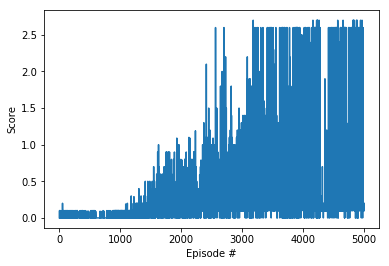

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()